In [355]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, make_scorer, mean_squared_error
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split, cross_val_score, \
StratifiedKFold, learning_curve, KFold, GridSearchCV

import xgboost as xgb
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from imblearn.over_sampling import ADASYN

In [356]:
data2 = pd.read_csv('/content/Data Kesehatan Karyawan-Data 1 n Data 2 - Data 2.csv')

In [357]:
data2

,Responden,Jenis Kelamin,Usia,Tekanan darah (S),Tekanan darah (D),Tinggi badan (cm),Berat badan (kg),IMT (kg/m2),Lingkar perut (cm),Glukosa Puasa (mg/dL),Cholesterol Total (mg/dL),Trigliserida (mg/dL),Fat,Visceral Fat,Masa Kerja,Tempat lahir
0,1,M,19.0,126.0,88.0,172.5,49.50,16.53,66.0,84.0,187.0,99.0,26.4,6.0,0.97,Purworejo
1,2,M,19.0,120.0,80.0,158.0,53.60,21.50,71.0,84.0,187.0,99.0,26.4,6.0,0.60,Bogor
2,3,M,19.0,120.0,80.0,170.0,59.50,20.59,80.0,80.0,187.0,99.0,26.4,6.0,1.37,bandung
3,4,F,19.0,100.0,70.0,149.0,45.10,20.31,62.0,81.0,187.0,99.0,30.5,3.5,1.00,Jakarta
4,5,M,19.0,110.0,70.0,171.6,62.40,21.19,78.0,84.0,187.0,99.0,26.4,6.0,4.00,Teluk Betung
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,1335,M,39.0,110.0,70.0,162.5,67.60,25.60,87.0,84.0,169.0,72.0,23.8,11.0,6.00,Bogor
1335,1336,F,39.0,120.0,70.0,150.0,60.50,26.90,77.0,84.0,199.0,105.0,38.1,9.0,6.15,Bogor
1336,1337,F,39.0,120.0,80.0,151.0,59.75,26.20,78.0,84.0,177.0,78.0,35.3,8.0,26.00,Bogor
1337,1338,M,39.0,110.0,70.0,166.2,57.00,20.63,69.0,84.0,244.0,98.0,17.1,5.0,4.30,Bogor


In [358]:
# Remove duplicates
data2 = data2.drop_duplicates()

# Reset index after removing duplicates
data2.reset_index(drop=True, inplace=True)

In [359]:
 data2 = data2[(data2['Tekanan darah  (S)'] < 160) & (data2['Berat badan (kg)'] < 125) & (data2['IMT (kg/m2)'] < 40 ) & (data2['Glukosa Puasa (mg/dL)'] < 200) & (data2['Trigliserida (mg/dL)'] < 500)]

# Explanation about 'Tempat lahir' Column

Given that there are so many unique values, and considering how in the real world, cholesterol can hit anyone despite of their region, I am going to assume that 'Tempat lahir' is "Totes Useless" or insiginificant to our prediction.

Trying to encode all of this would also be inefficient.

Furthermore, if theoretically, it just so happens that, for example, more Jakartans have more cholesterol, that's just because we have more samples of Jakartans in the dataset.

Additionally, this would eliminate the need to for us to deal with any other object column in our processing and modelling, thereby optimizing our workload.

For those reasons, I am going to drop 'Tempat lahir' column from my consideration.

In [360]:
data2.drop(['Responden','Tempat lahir'], axis=1, inplace=True)

In [361]:
encoder = OrdinalEncoder()

# Fit and transform the encoder on the selected column
encoded_column2 = encoder.fit_transform(data2['Jenis Kelamin'].values.reshape(-1, 1))

# Replace the original column with the encoded values
data2['Jenis Kelamin'] = encoded_column2
data2

,Jenis Kelamin,Usia,Tekanan darah (S),Tekanan darah (D),Tinggi badan (cm),Berat badan (kg),IMT (kg/m2),Lingkar perut (cm),Glukosa Puasa (mg/dL),Cholesterol Total (mg/dL),Trigliserida (mg/dL),Fat,Visceral Fat,Masa Kerja
0,1.0,19.0,126.0,88.0,172.5,49.50,16.53,66.0,84.0,187.0,99.0,26.4,6.0,0.97
1,1.0,19.0,120.0,80.0,158.0,53.60,21.50,71.0,84.0,187.0,99.0,26.4,6.0,0.60
2,1.0,19.0,120.0,80.0,170.0,59.50,20.59,80.0,80.0,187.0,99.0,26.4,6.0,1.37
3,0.0,19.0,100.0,70.0,149.0,45.10,20.31,62.0,81.0,187.0,99.0,30.5,3.5,1.00
4,1.0,19.0,110.0,70.0,171.6,62.40,21.19,78.0,84.0,187.0,99.0,26.4,6.0,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,1.0,39.0,110.0,70.0,162.5,67.60,25.60,87.0,84.0,169.0,72.0,23.8,11.0,6.00
1335,0.0,39.0,120.0,70.0,150.0,60.50,26.90,77.0,84.0,199.0,105.0,38.1,9.0,6.15
1336,0.0,39.0,120.0,80.0,151.0,59.75,26.20,78.0,84.0,177.0,78.0,35.3,8.0,26.00
1337,1.0,39.0,110.0,70.0,166.2,57.00,20.63,69.0,84.0,244.0,98.0,17.1,5.0,4.30


In [362]:
data2.reset_index(drop=True, inplace=True)
data2

,Jenis Kelamin,Usia,Tekanan darah (S),Tekanan darah (D),Tinggi badan (cm),Berat badan (kg),IMT (kg/m2),Lingkar perut (cm),Glukosa Puasa (mg/dL),Cholesterol Total (mg/dL),Trigliserida (mg/dL),Fat,Visceral Fat,Masa Kerja
0,1.0,19.0,126.0,88.0,172.5,49.50,16.53,66.0,84.0,187.0,99.0,26.4,6.0,0.97
1,1.0,19.0,120.0,80.0,158.0,53.60,21.50,71.0,84.0,187.0,99.0,26.4,6.0,0.60
2,1.0,19.0,120.0,80.0,170.0,59.50,20.59,80.0,80.0,187.0,99.0,26.4,6.0,1.37
3,0.0,19.0,100.0,70.0,149.0,45.10,20.31,62.0,81.0,187.0,99.0,30.5,3.5,1.00
4,1.0,19.0,110.0,70.0,171.6,62.40,21.19,78.0,84.0,187.0,99.0,26.4,6.0,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325,1.0,39.0,110.0,70.0,162.5,67.60,25.60,87.0,84.0,169.0,72.0,23.8,11.0,6.00
1326,0.0,39.0,120.0,70.0,150.0,60.50,26.90,77.0,84.0,199.0,105.0,38.1,9.0,6.15
1327,0.0,39.0,120.0,80.0,151.0,59.75,26.20,78.0,84.0,177.0,78.0,35.3,8.0,26.00
1328,1.0,39.0,110.0,70.0,166.2,57.00,20.63,69.0,84.0,244.0,98.0,17.1,5.0,4.30


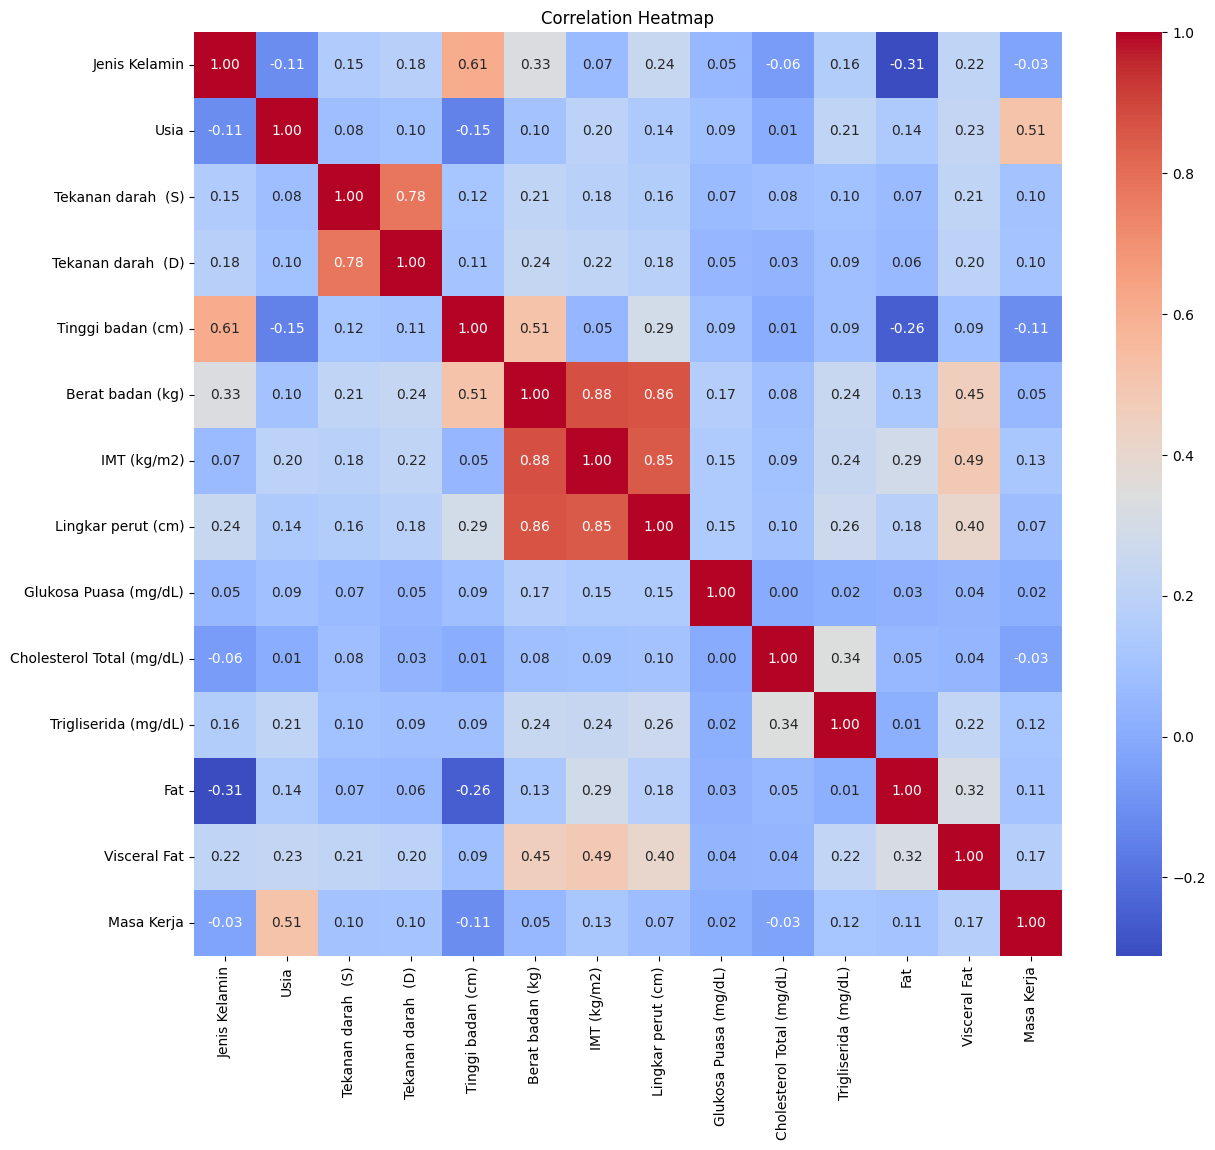

In [363]:
# Assuming data2 is your DataFrame
correlation_matrix = data2.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Heatmap Explained

If we focus on the row that says 'Cholesterol Total (mg/dL)' all features have a correlation, at most 8% (0.08).

However, the single most impactful feature is 'Trigliserida (mg/dL)'. I suspect that it is the main composition of those cholesterols, more research is needed.

In [364]:
data2['High (1) or Low (0) Chol.'] = pd.cut(data2['Cholesterol Total (mg/dL)'],
                                   bins=[-float("inf"), 200, float("inf")],
                                  labels=[0, 1])

data2['High (1) or Low (0) Chol.'] = data2['High (1) or Low (0) Chol.'].astype(bool)

# sns.pairplot(data2, hue='Cholesterol_Level')
# plt.title('Pairplot of Data with Cholesterol Level')
# plt.show()

In [365]:
# label_encoder = LabelEncoder()

# # Encode the labels
# data2['Cholesterol_Level_Encoded'] = label_encoder.fit_transform(data2['Cholesterol_Level'])

In [366]:
data2

,Jenis Kelamin,Usia,Tekanan darah (S),Tekanan darah (D),Tinggi badan (cm),Berat badan (kg),IMT (kg/m2),Lingkar perut (cm),Glukosa Puasa (mg/dL),Cholesterol Total (mg/dL),Trigliserida (mg/dL),Fat,Visceral Fat,Masa Kerja,High (1) or Low (0) Chol.
0,1.0,19.0,126.0,88.0,172.5,49.50,16.53,66.0,84.0,187.0,99.0,26.4,6.0,0.97,False
1,1.0,19.0,120.0,80.0,158.0,53.60,21.50,71.0,84.0,187.0,99.0,26.4,6.0,0.60,False
2,1.0,19.0,120.0,80.0,170.0,59.50,20.59,80.0,80.0,187.0,99.0,26.4,6.0,1.37,False
3,0.0,19.0,100.0,70.0,149.0,45.10,20.31,62.0,81.0,187.0,99.0,30.5,3.5,1.00,False
4,1.0,19.0,110.0,70.0,171.6,62.40,21.19,78.0,84.0,187.0,99.0,26.4,6.0,4.00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325,1.0,39.0,110.0,70.0,162.5,67.60,25.60,87.0,84.0,169.0,72.0,23.8,11.0,6.00,False
1326,0.0,39.0,120.0,70.0,150.0,60.50,26.90,77.0,84.0,199.0,105.0,38.1,9.0,6.15,False
1327,0.0,39.0,120.0,80.0,151.0,59.75,26.20,78.0,84.0,177.0,78.0,35.3,8.0,26.00,False
1328,1.0,39.0,110.0,70.0,166.2,57.00,20.63,69.0,84.0,244.0,98.0,17.1,5.0,4.30,True


In [367]:
# ranges = [(21, 35), (36, 50), (51, 65)]

# # Perform one-hot encoding
# for start, end in ranges:
#     column_name = f'{start}-{end}'
#     data2[column_name] = data2['Usia'].apply(lambda x: 1 if start <= x <= end else 0)

# # Drop the original 'age' column
# data2.drop(columns=['Usia'], inplace=True)

# data2

In [368]:
column_mapping = {'IMT (kg/m2)': 'BMI (kg/m2)'}
data2.rename(columns=column_mapping, inplace=True)
data2

,Jenis Kelamin,Usia,Tekanan darah (S),Tekanan darah (D),Tinggi badan (cm),Berat badan (kg),BMI (kg/m2),Lingkar perut (cm),Glukosa Puasa (mg/dL),Cholesterol Total (mg/dL),Trigliserida (mg/dL),Fat,Visceral Fat,Masa Kerja,High (1) or Low (0) Chol.
0,1.0,19.0,126.0,88.0,172.5,49.50,16.53,66.0,84.0,187.0,99.0,26.4,6.0,0.97,False
1,1.0,19.0,120.0,80.0,158.0,53.60,21.50,71.0,84.0,187.0,99.0,26.4,6.0,0.60,False
2,1.0,19.0,120.0,80.0,170.0,59.50,20.59,80.0,80.0,187.0,99.0,26.4,6.0,1.37,False
3,0.0,19.0,100.0,70.0,149.0,45.10,20.31,62.0,81.0,187.0,99.0,30.5,3.5,1.00,False
4,1.0,19.0,110.0,70.0,171.6,62.40,21.19,78.0,84.0,187.0,99.0,26.4,6.0,4.00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325,1.0,39.0,110.0,70.0,162.5,67.60,25.60,87.0,84.0,169.0,72.0,23.8,11.0,6.00,False
1326,0.0,39.0,120.0,70.0,150.0,60.50,26.90,77.0,84.0,199.0,105.0,38.1,9.0,6.15,False
1327,0.0,39.0,120.0,80.0,151.0,59.75,26.20,78.0,84.0,177.0,78.0,35.3,8.0,26.00,False
1328,1.0,39.0,110.0,70.0,166.2,57.00,20.63,69.0,84.0,244.0,98.0,17.1,5.0,4.30,True


In [369]:
# bmi_ranges = [(0, 18.5), (18.5, 25.0), (25.0, 30.0), (30.0, float('inf'))]
# categories = ['Underweight', 'Normal', 'Overweight', 'Obese']

# # Perform one-hot encoding for BMI ranges
# for i, (start, end) in enumerate(bmi_ranges):
#     category = categories[i]
#     column_name = category.replace(' ', '_').lower()  # Replace spaces with underscores and convert to lowercase
#     data2[column_name] = data2['BMI (kg/m2)'].apply(lambda x: 1 if start < x <= end else 0)

# # Drop the original 'bmi' column
# # data2.drop(columns=['BMI (kg/m2)'], inplace=True)

# data2

In [370]:
data2.drop(columns=['Tinggi badan (cm)', 'Berat badan (kg)'], inplace=True)
data2

,Jenis Kelamin,Usia,Tekanan darah (S),Tekanan darah (D),BMI (kg/m2),Lingkar perut (cm),Glukosa Puasa (mg/dL),Cholesterol Total (mg/dL),Trigliserida (mg/dL),Fat,Visceral Fat,Masa Kerja,High (1) or Low (0) Chol.
0,1.0,19.0,126.0,88.0,16.53,66.0,84.0,187.0,99.0,26.4,6.0,0.97,False
1,1.0,19.0,120.0,80.0,21.50,71.0,84.0,187.0,99.0,26.4,6.0,0.60,False
2,1.0,19.0,120.0,80.0,20.59,80.0,80.0,187.0,99.0,26.4,6.0,1.37,False
3,0.0,19.0,100.0,70.0,20.31,62.0,81.0,187.0,99.0,30.5,3.5,1.00,False
4,1.0,19.0,110.0,70.0,21.19,78.0,84.0,187.0,99.0,26.4,6.0,4.00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325,1.0,39.0,110.0,70.0,25.60,87.0,84.0,169.0,72.0,23.8,11.0,6.00,False
1326,0.0,39.0,120.0,70.0,26.90,77.0,84.0,199.0,105.0,38.1,9.0,6.15,False
1327,0.0,39.0,120.0,80.0,26.20,78.0,84.0,177.0,78.0,35.3,8.0,26.00,False
1328,1.0,39.0,110.0,70.0,20.63,69.0,84.0,244.0,98.0,17.1,5.0,4.30,True


In [371]:
# data2[['21-35', '36-50', '51-65', 'underweight', 'normal', 'overweight', 'obese']] = data2[['21-35', '36-50', '51-65', 'underweight', 'normal', 'overweight', 'obese']].astype(bool)

In [372]:
data2

,Jenis Kelamin,Usia,Tekanan darah (S),Tekanan darah (D),BMI (kg/m2),Lingkar perut (cm),Glukosa Puasa (mg/dL),Cholesterol Total (mg/dL),Trigliserida (mg/dL),Fat,Visceral Fat,Masa Kerja,High (1) or Low (0) Chol.
0,1.0,19.0,126.0,88.0,16.53,66.0,84.0,187.0,99.0,26.4,6.0,0.97,False
1,1.0,19.0,120.0,80.0,21.50,71.0,84.0,187.0,99.0,26.4,6.0,0.60,False
2,1.0,19.0,120.0,80.0,20.59,80.0,80.0,187.0,99.0,26.4,6.0,1.37,False
3,0.0,19.0,100.0,70.0,20.31,62.0,81.0,187.0,99.0,30.5,3.5,1.00,False
4,1.0,19.0,110.0,70.0,21.19,78.0,84.0,187.0,99.0,26.4,6.0,4.00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325,1.0,39.0,110.0,70.0,25.60,87.0,84.0,169.0,72.0,23.8,11.0,6.00,False
1326,0.0,39.0,120.0,70.0,26.90,77.0,84.0,199.0,105.0,38.1,9.0,6.15,False
1327,0.0,39.0,120.0,80.0,26.20,78.0,84.0,177.0,78.0,35.3,8.0,26.00,False
1328,1.0,39.0,110.0,70.0,20.63,69.0,84.0,244.0,98.0,17.1,5.0,4.30,True


In [373]:
# data2.drop(columns=['Cholesterol Total (mg/dL)'], axis=1, inplace=True)
# data2

In [374]:
X = data2.drop('High (1) or Low (0) Chol.', axis=1)  # Features
y = data2['High (1) or Low (0) Chol.']                # Target

# Initialize logistic regression model
model = LogisticRegression(max_iter=10000, random_state=42)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform ADASYN resampling
adasyn = ADASYN(sampling_strategy='minority', n_neighbors=5)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

In [375]:
X_resampled.drop('Cholesterol Total (mg/dL)', axis=1, inplace=True)
X_test.drop('Cholesterol Total (mg/dL)', axis=1, inplace=True)

In [376]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [377]:
# Define the logistic regression model
model = LogisticRegression(max_iter = 10000, random_state=42)

# Define the grid of hyperparameters to search
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1')
grid_search.fit(X_resampled, y_resampled)

# Print the best parameters found
print("Best parameters found: ", grid_search.best_params_)

# Train a logistic regression model with the best parameters
best_model = LogisticRegression(**grid_search.best_params_, max_iter = 10000, random_state=42)
best_model.fit(X_resampled, y_resampled)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
accuracy = f1_score(y_test, y_pred)
print("Accuracy on test set: ", accuracy)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=5, scoring='f1')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:  {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy on test set:  0.34146341463414637
Cross-validation scores: [0.7150838  0.68292683 0.63253012 0.6954023  0.84711779]
Mean cross-validation score: 0.7146121683939384


In [378]:
y_test.describe()

count       266
unique        2
top       False
freq        232
Name: High (1) or Low (0) Chol., dtype: object

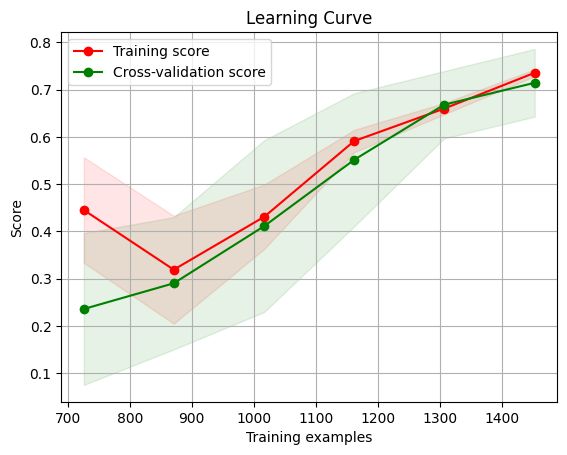

In [379]:
plot_learning_curve(best_model, "Learning Curve", X_resampled, y_resampled, cv=5, n_jobs=-1)
plt.show()

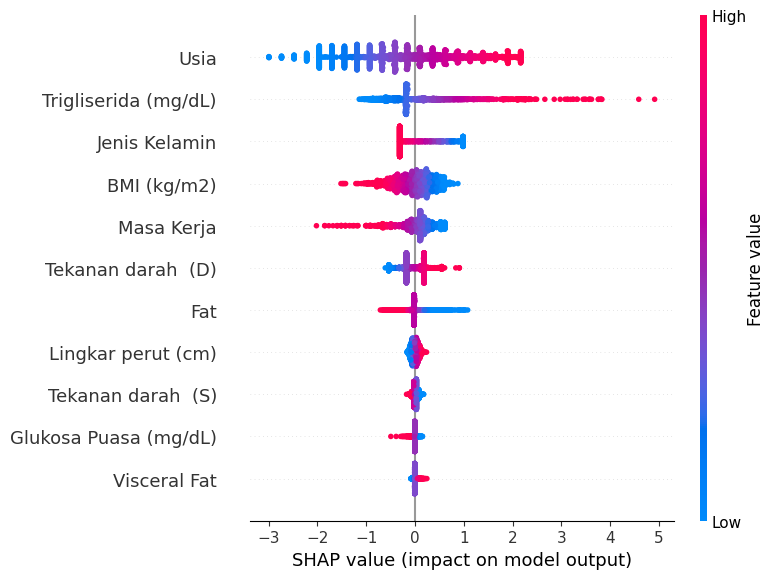

In [380]:
!pip install shap
import shap

# Create a SHAP explainer object
explainer = shap.Explainer(best_model, X_resampled)

# Calculate SHAP values for all features
shap_values = explainer.shap_values(X_resampled)

# Visualize the SHAP values for a single prediction (e.g., the first sample in your dataset)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_resampled.iloc[0, :])

# Summary plot showing the impact of each feature on the model output across all samples
shap.summary_plot(shap_values, X_resampled)

# # Dependence plot showing how a single feature affects the output of the model
# shap.dependence_plot("Feature_name", shap_values, X_resampled)

In [381]:
# # Train logistic regression model on the resampled data
# model.fit(X_resampled, y_resampled)

# # Make predictions on the test set
# y_pred = model.predict(X_test)

# # Calculate F1 score
# f1 = f1_score(y_test, y_pred)
# print("F1 Score:", f1)

# # Define a custom scorer for cross-validation (F1 score)
# custom_scorer = make_scorer(f1_score)

# # Initialize StratifiedKFold for cross-validation
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Lists to store cross-validation scores
# cv_scores = []

# # Iterate over each fold
# for train_index, test_index in skf.split(X, y):
#     X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
#     y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

#     # Apply ADASYN resampling
#     adasyn = ADASYN(sampling_strategy='minority', random_state=42)
#     X_resampled_fold, y_resampled_fold = adasyn.fit_resample(X_train_fold, y_train_fold)

#     # Shuffle the resampled data
#     X_resampled_fold, y_resampled_fold = shuffle(X_resampled_fold, y_resampled_fold, random_state=42)

#     # Train logistic regression model on the resampled fold
#     model.fit(X_resampled_fold, y_resampled_fold)

#     # Make predictions on the test fold
#     y_pred_fold = model.predict(X_test_fold)

#     # Calculate F1 score for this fold
#     fold_f1 = f1_score(y_test_fold, y_pred_fold)
#     cv_scores.append(fold_f1)

# # Print cross-validation scores
# print("Cross-validation F1 scores:", cv_scores)
# print("Mean cross-validation F1 score:", np.mean(cv_scores))

# # Plot learning curve
# title = "Learning Curves (Logistic Regression)"
# plot_learning_curve(model, title, X, y, cv=5, n_jobs=-1)
# plt.show()

In [382]:
# def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
#                         n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
#     plt.figure()
#     plt.title(title)
#     if ylim is not None:
#         plt.ylim(*ylim)
#     plt.xlabel("Training examples")
#     plt.ylabel("Score")
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=custom_scorer)  # Use custom scorer for RMSE
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
#     plt.grid()

#     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1,
#                      color="r")
#     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
#              label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
#              label="Cross-validation score")

#     plt.legend(loc="best")
#     return plt


In [383]:
# # Define a custom scorer for cross-validation (RMSE)
# def custom_scorer(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

# # Initialize StratifiedKFold for cross-validation
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Lists to store cross-validation scores
# cv_scores = []

# # Initialize XGBoost regressor
# model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3)

# # Iterate over each fold
# for train_index, test_index in skf.split(X, y):
#     X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
#     y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

#     # Apply ADASYN resampling
#     adasyn = ADASYN(sampling_strategy='minority', random_state=42)
#     X_resampled_fold, y_resampled_fold = adasyn.fit_resample(X_train_fold, y_train_fold)

#     # Shuffle the resampled data
#     X_resampled_fold, y_resampled_fold = shuffle(X_resampled_fold, y_resampled_fold, random_state=42)

#     # Train XGBoost regressor on the resampled fold
#     model.fit(X_resampled_fold, y_resampled_fold)

#     # Make predictions on the test fold
#     y_pred_fold = model.predict(X_test_fold)

#     # Calculate RMSE for this fold
#     fold_rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
#     cv_scores.append(fold_rmse)

# # Print cross-validation scores
# print("Cross-validation RMSE scores:", cv_scores)
# print("Mean cross-validation RMSE score:", np.mean(cv_scores))

# # Plot learning curve
# title = "Learning Curves (XGBoost Regression)"
# plot_learning_curve(model, title, X, y, cv=5, n_jobs=-1)
# plt.show()


In [384]:
# data2.drop(columns=['BMI (kg/m2)', '21-35', '36-50', '51-65',
#                     'underweight', 'normal', 'overweight', 'obese'], inplace=True)

In [385]:
X_resampled.columns

Index(['Jenis Kelamin', 'Usia', 'Tekanan darah  (S)', 'Tekanan darah  (D)',
       'BMI (kg/m2)', 'Lingkar perut (cm)', 'Glukosa Puasa (mg/dL)',
       'Trigliserida (mg/dL)', 'Fat', 'Visceral Fat', 'Masa Kerja'],
      dtype='object')